# TP : Prédiction Météo Multivariée avec LSTM
---
Les données [jena_climate_2009_2016](https://www.kaggle.com/datasets/stytch16/jena-climate-2009-2016)

Pour le Dataset `CatsVsDogs` vous avez utilisé : `image_dataset_from_directory` pour lire les images à la volée. 
Ici on va créer à la volée, à partir des données contenu dans une array, des timeseries avec la fonction `timeseries_dataset_from_array`.

### Exercice 1 : Prédiction à court terme (Single-Step)

**Objectif :** Prédire la température précise qu'il fera dans exactement **1 heure**.

* **Données d'entrée :** On utilise un historique de **24 heures** (soit 24 lignes si vos données sont échantillonnées à l'heure). Vous devez utiliser au moins 3 variables (ex: Température, Pression, Humidité).
* **Cible :** La température à .
* **Architecture demandée :** 
  * Une couche `LSTM`.
  * Une couche `Dense` de sortie avec **1 seul neurone**.


* **Question :** Comparez la courbe prédite à la courbe réelle. Le modèle arrive-t-il à anticiper les changements brusques ou se contente-t-il de "suivre" la valeur précédente ?

Calculez l'erreur moyenne (MAE).

---



In [121]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import Sequential
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

plt.style.use('dark_background')
plt.rcParams['axes.facecolor'] = "#2c2c2cff"
plt.rcParams['figure.facecolor'] = "#2c2c2cff"
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams['grid.linestyle'] = "--"
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['axes.grid'] = True

In [98]:

df = pd.read_csv('jena_climate_2009_2016.csv')
print(df.columns)
df.head(10)

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='str')


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
6,01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
7,01.01.2009 01:20:00,996.50,-7.62,265.81,-8.36,94.4,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,0.50,118.6
8,01.01.2009 01:30:00,996.50,-7.91,265.52,-8.73,93.8,3.36,3.15,0.21,1.97,3.16,1307.17,0.28,0.75,188.5
9,01.01.2009 01:40:00,996.53,-8.43,264.99,-9.34,93.1,3.23,3.00,0.22,1.88,3.02,1309.85,0.59,0.88,185.0


In [159]:
df500 = df.iloc[:6 * 24 * 5 ]

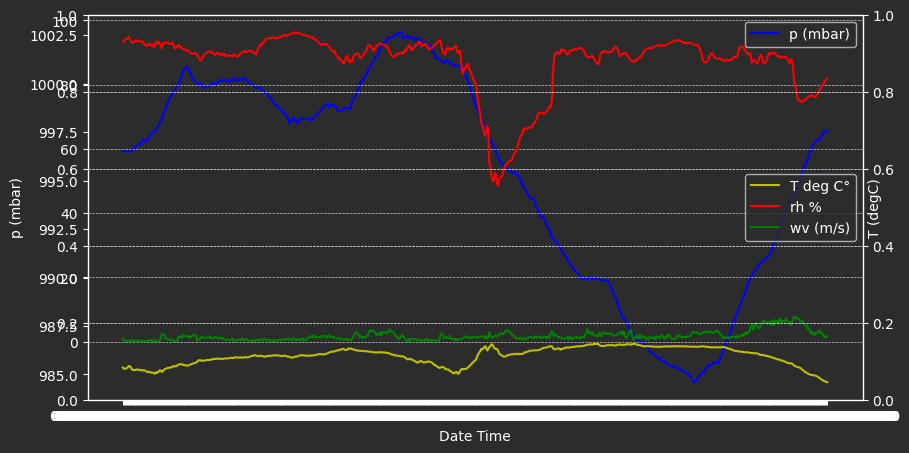

In [160]:

fig, ax1 = plt.subplots(figsize=(10, 5))

sns.lineplot(data=df500, x="Date Time", y="p (mbar)", ax=ax1, label="p (mbar)", c = 'b')

ax2 = ax1.twinx()
sns.lineplot( data=df500, x="Date Time", y="T (degC)", ax=ax2, label="T deg C°", c = 'y')

ax3 = ax2.twinx()
sns.lineplot( data=df500, x="Date Time", y="rh (%)", ax=ax2, label="rh %", c = 'r')

ax4 = ax3.twinx()
sns.lineplot( data=df500, x="Date Time", y="wv (m/s)", ax=ax2, label="wv (m/s)", c = 'g')

ax1.grid(False)
plt.show()

In [101]:
features = ["T (degC)", "p (mbar)", "rh (%)", "wv (m/s)"]
target = "T (degC)"

data = df[features].values
target_data = df[target].values
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)



In [102]:
past = 6 * 24        # 24 heures d'historique
future = 6       # prédiction à t+1
batch_size = 32

In [103]:
split = int(0.8 * len(data_scaled))

x_train = data_scaled[:split]
y_train = target_data[:split]

x_val = data_scaled[split:]
y_val = target_data[split:]

In [104]:
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    data=x_train,
    targets=y_train[past:],
    sequence_length=past,
    batch_size=batch_size
)

val_ds = tf.keras.utils.timeseries_dataset_from_array(
    data=x_val,
    targets=y_val[past:],
    sequence_length=past,
    batch_size=batch_size
)

In [105]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(past, len(features))),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1)
])

model.compile(
    optimizer="adam",
    loss="mae"
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

In [106]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
10510/10510 ━━━━━━━━━━━━━━━━━━━━ 246s 23ms/step - loss: 1.0110 - val_loss: 0.2511
Epoch 2/10
10510/10510 ━━━━━━━━━━━━━━━━━━━━ 235s 22ms/step - loss: 0.1899 - val_loss: 0.2127
Epoch 3/10
10510/10510 ━━━━━━━━━━━━━━━━━━━━ 240s 23ms/step - loss: 0.1573 - val_loss: 0.1645
Epoch 4/10
10510/10510 ━━━━━━━━━━━━━━━━━━━━ 269s 26ms/step - loss: 0.1519 - val_loss: 0.1530
Epoch 5/10
10510/10510 ━━━━━━━━━━━━━━━━━━━━ 242s 23ms/step - loss: 0.1466 - val_loss: 0.1424
Epoch 6/10
10510/10510 ━━━━━━━━━━━━━━━━━━━━ 301s 29ms/step - loss: 0.1432 - val_loss: 0.1451
Epoch 7/10
10510/10510 ━━━━━━━━━━━━━━━━━━━━ 300s 29ms/step - loss: 0.1449 - val_loss: 0.1485
Epoch 8/10
10510/10510 ━━━━━━━━━━━━━━━━━━━━ 300s 29ms/step - loss: 0.1456 - val_loss: 0.1520
Epoch 9/10
10510/10510 ━━━━━━━━━━━━━━━━━━━━ 302s 29ms/step - loss: 0.1420 - val_loss: 0.1462
Epoch 10/10
10510/10510 ━━━━━━━━━━━━━━━━━━━━ 300s 29ms/step - loss: 0.1394 - val_loss: 0.1424


In [111]:
y_true = []
y_pred = []

for x, y in val_ds:
    pred = model.predict(x, verbose=0)
    y_true.extend(y.numpy())
    y_pred.extend(pred.flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

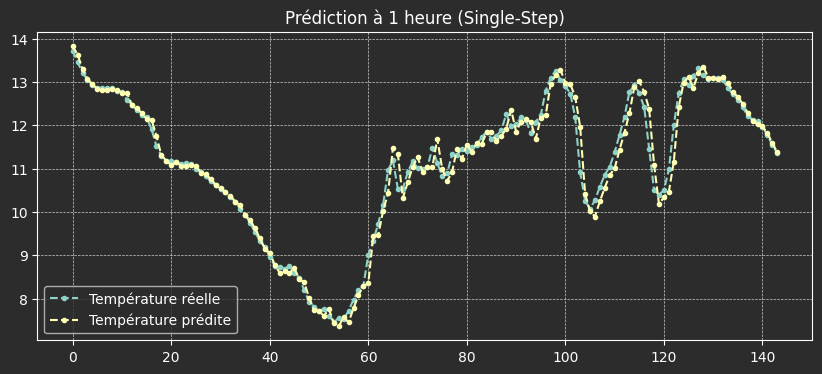

In [108]:
plt.figure(figsize=(10,4))
plt.plot(y_true[:24 *6 *1], label="Température réelle", marker="o", linestyle="--", markersize=3)
plt.plot(y_pred[:24 *6 *1], label="Température prédite", marker="o", linestyle="--", markersize=3)
plt.legend()
plt.title("Prédiction à 1 heure (Single-Step)")
plt.show()

In [109]:
mae = mean_absolute_error(y_true, y_pred)
print("MAE =", mae)

MAE = 0.14238739409346712


### Exercice 2 : Prédiction de trajectoire (Multi-Step)

**Objectif :** Prédire l'évolution de la température pour les **12 prochaines heures** d'un seul coup.

* **Données d'entrée :** On garde le même historique de **24 heures** et les mêmes variables multivariées.
* **Cible :** Un vecteur contenant les **12 prochaines valeurs** de température (de  à ).
* **Architecture demandée :** 
  * Une couche `LSTM` (pensez à ajuster le nombre d'unités).
  * Une couche `Dense` de sortie avec **12 neurones** (un par heure à prédire).


* **Analyse des résultats :** 1. Affichez une prédiction sur un graphique : l'historique (24h) en bleu, la réalité (12h) en vert et la prédiction (12h) en rouge.
1. Calculez l'erreur moyenne (MAE). Est-elle plus élevée que dans l'exercice 1 ? Pourquoi ?
2. Observez la "forme" de la prédiction : le modèle arrive-t-il à reproduire le cycle jour/nuit ?

Coup de main pour créer les cibles : 
```python
Y_train = np.lib.stride_tricks.sliding_window_view(train[WINDOW:], window_shape=HORIZON)
```
Essayez de comprendre ce que fait cette fonction.
---

### Conseils pour la réussite du TP :

1. **Normalisation :** N'oubliez pas que la pression et la température n'ont pas les mêmes échelles. Un `StandardScaler` sur vos colonnes de caractéristiques est indispensable.
2. **Slicing :** Pour l'exercice 2, assurez-vous que votre générateur de données (ou votre fonction de fenêtrage) renvoie bien un tableau de forme `(12,)` pour chaque label .
3. **Complexité :** Si le modèle de l'exercice 2 a du mal à converger, essayez d'ajouter une deuxième couche `LSTM` ou d'augmenter le nombre de neurones dans la couche `Dense`.


In [ ]:
features = ["T (degC)", "p (mbar)", "rh (%)", "wv (m/s)"]
target = "T (degC)"

data = df[features].values
target_data = df[target].values

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

In [161]:
split = int(0.8 * len(data_scaled))

x_train = data_scaled[:split]
x_val = data_scaled[split:]

y_train_full = target_data[:split]
y_val_full = target_data[split:]

x_train.shape, x_val.shape, y_train.shape, y_val.shape

((336440, 4), (84111, 4), (336440,), (84111,))

In [113]:
WINDOW = 24
HORIZON = 12

In [ ]:
Y_train = np.lib.stride_tricks.sliding_window_view(y_train_full[WINDOW:], window_shape=HORIZON)
Y_val = np.lib.stride_tricks.sliding_window_view(y_val_full[WINDOW:], window_shape=HORIZON)

X_train_ds = x_train[:-HORIZON]  # убираем последние HORIZON точек, чтобы совпадали с Y_train
X_val_ds = x_val[:-HORIZON]

train_ds = tf.keras.utils.timeseries_dataset_from_array(
    data=X_train_ds,
    targets=Y_train,
    sequence_length=WINDOW,
    batch_size=batch_size
)

val_ds = tf.keras.utils.timeseries_dataset_from_array(
    data=X_val_ds,
    targets=Y_val,
    sequence_length=WINDOW,
    batch_size=batch_size
)

X_train_ds.shape

(336405, 12)


(336428, 4)

In [145]:
Y_train.shape

(336405, 12)

In [146]:


model_2 = Sequential([
    LSTM(128, input_shape=(WINDOW, len(features))),  # вход: 24 часа × 3 признака
    Dense(HORIZON)  # выход: 12 значений
])

model_2.compile(optimizer="adam", loss="mae")
model_2.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 128)            │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,644 (272.05 KB)

 Trainable params: 69,644 (272.05 KB)

 Non-trainable params: 0 (0.00 B)

In [147]:
for x, y in train_ds.take(1):
    print(x.shape)  # (batch, 24, 3)
    print(y.shape)  # (batch, 12)

(32, 24, 4)
(32, 12)


In [148]:
history = model_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
10513/10513 ━━━━━━━━━━━━━━━━━━━━ 113s 11ms/step - loss: 2.3531 - val_loss: 3.5583
Epoch 2/10
10513/10513 ━━━━━━━━━━━━━━━━━━━━ 111s 11ms/step - loss: 0.6702 - val_loss: 3.6069
Epoch 3/10
10513/10513 ━━━━━━━━━━━━━━━━━━━━ 112s 11ms/step - loss: 0.5972 - val_loss: 3.5878
Epoch 4/10
10513/10513 ━━━━━━━━━━━━━━━━━━━━ 113s 11ms/step - loss: 0.5727 - val_loss: 3.5918
Epoch 5/10
10513/10513 ━━━━━━━━━━━━━━━━━━━━ 115s 11ms/step - loss: 0.5587 - val_loss: 3.6090
Epoch 6/10
 4020/10513 ━━━━━━━━━━━━━━━━━━━━ 49s 8ms/step - loss: 0.5742

KeyboardInterrupt: 

In [157]:
for x, y in val_ds.take(1):
    x_sample = x[0]   # (24, 3)
    y_true   = y[0]   # (12,)
    y_pred   = model_2.predict(x_sample[None, ...], verbose=0)[0]  # (12,)

t_hist = range(WINDOW)
t_fut  = range(WINDOW, WINDOW + HORIZON)

ValueError: x and y must have same first dimension, but have shapes (24,) and (144,)

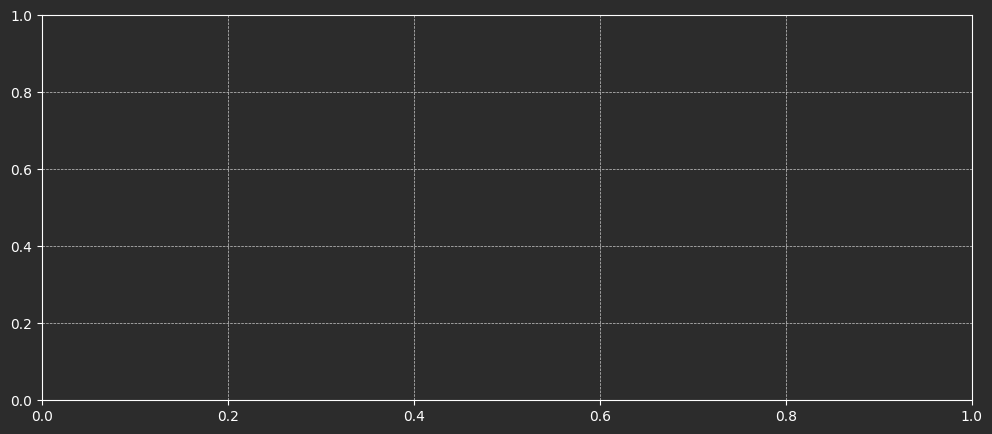

In [158]:
plt.figure(figsize=(12,5))

# История (24h)
plt.plot(
    t_hist,
    x_sample[:, 0],          # 0-й признак = T (degC)
    label="История (24h)",
    color="blue"
)

# Реальность (12h)
plt.plot(
    t_fut,
    y_true,
    label="Реальность (12h)",
    color="green"
)

# Прогноз (12h)
plt.plot(
    t_fut,
    y_pred,
    label="Прогноз (12h)",
    color="red",
    linestyle="--",
    marker="o",
    markersize=3
)

plt.xlabel("Часы")
plt.ylabel("Температура (°C)")
plt.legend()
plt.grid(True)
plt.show()
